In [1]:
# Importing libraries required
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import seaborn as sns # Data visualization
import matplotlib.pyplot as plt # Data visualization

# Handle Imbalanced dataset
from imblearn.over_sampling import SMOTE

# Print html elements
from IPython.display import Markdown

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#To make working with geospatial data in python easier
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

plt.style.use('ggplot')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/electric-vehicle-population/Electric_Vehicle_Population.csv")
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,3MW5P9J05N,Arapahoe,Englewood,CO,80111.000,2022,BMW,330E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,0,NaN,200589147,POINT (-104.89239 39.61914),NaN,8005006861.000
1,5YJXCBE27J,Island,Greenbank,WA,98253.000,2018,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,10.000,326880081,POINT (-122.575569 48.08489),NaN,53029971302.000
2,1N4AZ0CP3F,Kings,Lemoore,CA,93245.000,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,NaN,182237457,POINT (-119.78637 36.30101),NaN,6031980000.000
3,5YJ3E1EA8J,San Diego,Oceanside,CA,92051.000,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,NaN,153998050,NaN,NaN,6073018509.000
4,5YJ3E1EB1K,Alameda,Berkeley,CA,94710.000,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,320914072,POINT (-122.300531 37.869271),NaN,6001423200.000


# Glossary / Data Dictionary / Important Terms

- 'VIN (1-10)': The 1st 10 characters of each vehicle's Vehicle Identification Number (VIN).
- 'County': The county in which the registered owner resides.
- 'City': The city in which the registered owner resides
- 'State': The state in which the registered owner resides
- 'Postal Code': The 5 digit zip code in which the registered owner resides
- 'Model Year': The model year of the vehicle, determined by decoding the Vehicle Identification Number (VIN)
- 'Make': The manufacturer of the vehicle, determined by decoding the Vehicle Identification Number (VIN)
- 'Model': The model of the vehicle, determined by decoding the Vehicle Identification Number (VIN).
- 'Electric Vehicle Type': This distinguishes the vehicle as all electric or a plug-in hybrid.
- 'Clean Alternative Fuel Vehicle (CAFV) Eligibility': This categorizes vehicle as Clean Alternative Fuel Vehicles (CAFVs) based on the fuel requirement and electric-only range requirement in House Bill 2042 as passed in the 2019 legislative session.

- 'Electric Range': Describes how far a vehicle can travel purely on its electric charge.
- 'Base MSRP': This is the lowest Manufacturer's Suggested Retail Price (MSRP) for any trim level of the model in question.
- 'Legislative District': The specific section of Washington State that the vehicle's owner resides in, as represented in the state legislature.
- 'DOL Vehicle ID': Unique number assigned to each vehicle by Department of Licensing for identification purposes.
- 'Vehicle Location': The center of the ZIP Code for the registered vehicle.
- 'Electric Utility': This is the electric power retail service territories serving the address of the registered vehicle. All ownership types for areas in Washington are included: federal, investor owned, municipal, political subdivision, and cooperative. If the address for the registered vehicle falls into an area with overlapping electric power retail service territories then a single pipe | delimits utilities of same TYPE and a double pipe || delimits utilities of different types. We combined vehicle address and Homeland Infrastructure Foundation Level Database (HIFLD) Retail_Service_Territories feature layer using a geographic information system to assign values for this field. Blanks occur for vehicles with addresses outside of Washington or for addresses falling into areas in Washington not containing a mapped electric power retail service territory in the source data.

- '2020 Census Tract': The census tract identifier is a combination of the state, county, and census tract codes as assigned by the United States Census Bureau in the 2020 census, also known as Geographic Identifier (GEOID)

In [3]:
df.shape

(109481, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109481 entries, 0 to 109480
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         109481 non-null  object 
 1   County                                             109480 non-null  object 
 2   City                                               109480 non-null  object 
 3   State                                              109481 non-null  object 
 4   Postal Code                                        109480 non-null  float64
 5   Model Year                                         109481 non-null  int64  
 6   Make                                               109481 non-null  object 
 7   Model                                              109474 non-null  object 
 8   Electric Vehicle Type                              109481 non-null  object

In [5]:
df.describe()

,Postal Code,Model Year,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,2020 Census Tract
count,109480.000,109481.000,109481.000,109481.000,109205.000,109481.000,109480.000
mean,98157.013,2018.899,90.211,1849.195,29.824,198447551.860,52968493402.103
std,2640.606,2.873,102.576,10946.085,14.680,95617186.542,1675103687.860
min,1730.000,1997.000,0.000,0.000,1.000,4777.000,1101001400.000
25%,98052.000,2017.000,0.000,0.000,18.000,146731322.000,53033008500.000
50%,98121.000,2019.000,35.000,0.000,34.000,187411808.000,53033029304.000
75%,98370.000,2021.000,208.000,0.000,43.000,216917571.000,53053072506.000
max,99701.000,2023.000,337.000,845000.000,49.000,479254772.000,56033000100.000


## Handling Missing Values

In [6]:
df.isnull().sum()

VIN (1-10)                                             0
County                                                 1
City                                                   1
State                                                  0
Postal Code                                            1
Model Year                                             0
Make                                                   0
Model                                                  7
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 276
DOL Vehicle ID                                         0
Vehicle Location                                      25
Electric Utility                                     428
2020 Census Tract                                      1
dtype: int64

In [7]:
df["Electric Utility"] = df["Electric Utility"].fillna(df["Electric Utility"].shape[0])
df["Vehicle Location"] = df["Vehicle Location"].fillna(df["Vehicle Location"].shape[0])
df["County"] = df["County"].fillna(df["County"].shape[0])
df["City"] = df["City"].fillna(df["City"].shape[0])
df["Postal Code"] = df["Postal Code"].fillna(df["Postal Code"].shape[0])
df["Model"] = df["Model"].fillna(df["Model"].shape[0])
df["2020 Census Tract"] = df["2020 Census Tract"].fillna(df["2020 Census Tract"].shape[0])
df["Legislative District"] = df["Legislative District"].fillna(df["Legislative District"].mean())
df["Legislative District"] = df["Legislative District"].fillna(df["Legislative District"].mean())

In [8]:
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64


## What ought to be done relevant to the project

Upon initial viewing of the data, it has come to our attention towards the relevance or irrelavnce of particular columns:

1. VIN (1-10): It is a unique identifier or index.
2. Postal Code: is stored as float format., we need to convert that into integer
3. Base MSRP: The lowest Manufacturer's Suggested Retail Price (MSRP), a very important column however we need to see the health of this column if it has been populated or not
4. Model Year, Make, Model: are already all presented by decoding the VIN (1-10) id.,
5. Electric Utility: represents Electric Retail Services. | represnets service provider from same vendors, || service provider from multiple vendors, Blank represents Not Available
6. Few column names are with spaces. We will rename these columns:
   1. Postal Code
   2. Model Year
   3. Electric Vehicle Type
   4. Clean Alternative Fuel Vehicle (CAFV) Eligibility
   5. Electric Range
   6. Base MSRP
   7. Legislative District
   8. DOL Vehicle ID
   9. Vehicle Location
   10. Electric Utility
   11. 2020 Census Tract
   

We Can present the information stored in the Electric Utility: |, || and blank as:\
However, before any renaming. We will see the health of the attribute in terms of NULL values
- Single Type Utility
- Multi type Utility
- Not Available
  
These columns may be purged at later stage of this analysis (if required)
- Base MSRP
- Legislative District

In [9]:
# rename columns
df = df.rename(columns={'Postal Code': 'PostalCode', 'Model Year': 'ModelYear', 'Electric Vehicle Type': 'Electric_Vehicle_Type',
                        'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'CAFV_Eligibility',
                        'Electric Range':'Electric_Range', 'Base MSRP': 'Base_MSRP', 'Legislative District':'Legislative_District',
                        'DOL Vehicle ID': 'DOL_Vehicle_ID',
                        'Vehicle Location':'Vehicle_Location',
                        'Electric Utility':'Electric_Utility',
                        '2020 Census Tract':'2020_Census_Tract',
                        'VIN (1-10)':'VIN'})
print(df.columns)

Index(['VIN', 'County', 'City', 'State', 'PostalCode', 'ModelYear', 'Make',
       'Model', 'Electric_Vehicle_Type', 'CAFV_Eligibility', 'Electric_Range',
       'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID',
       'Vehicle_Location', 'Electric_Utility', '2020_Census_Tract'],
      dtype='object')


## Exploratory Data Analysis

In [10]:
df.columns

Index(['VIN', 'County', 'City', 'State', 'PostalCode', 'ModelYear', 'Make',
       'Model', 'Electric_Vehicle_Type', 'CAFV_Eligibility', 'Electric_Range',
       'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID',
       'Vehicle_Location', 'Electric_Utility', '2020_Census_Tract'],
      dtype='object')

In [11]:
df["Electric_Vehicle_Type"].value_counts()

Battery Electric Vehicle (BEV)            82819
Plug-in Hybrid Electric Vehicle (PHEV)    26662
Name: Electric_Vehicle_Type, dtype: int64

In [12]:
print("Number of unique Electric Vehicles Types: ", df["Electric_Vehicle_Type"].nunique(), "\nUnique Electric Vehicles Types: ", df["Electric_Vehicle_Type"].unique())

Number of unique Electric Vehicles Types:  2 
Unique Electric Vehicles Types:  ['Plug-in Hybrid Electric Vehicle (PHEV)' 'Battery Electric Vehicle (BEV)']


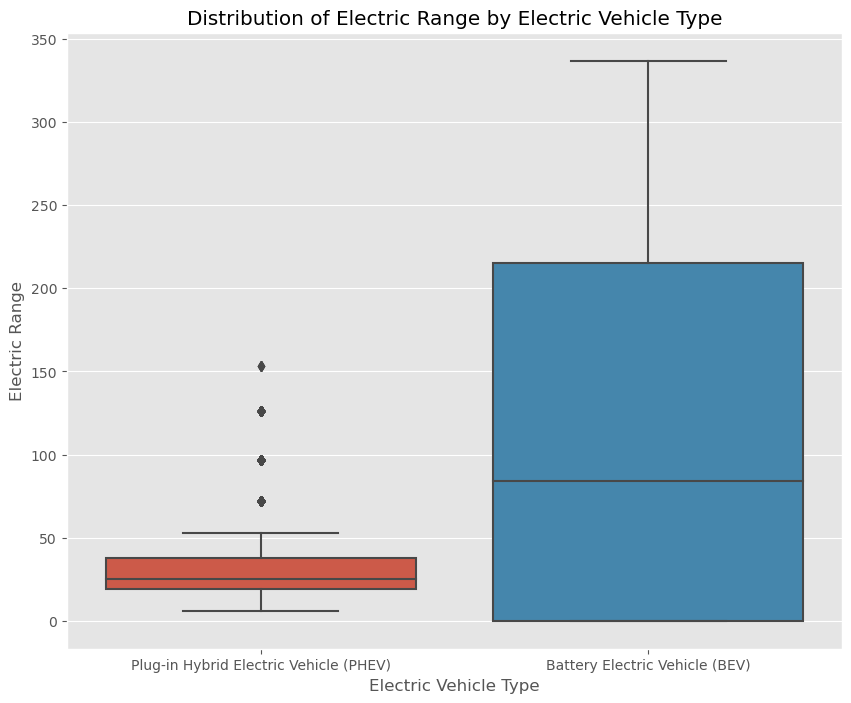

In [13]:
# adjust figure size
plt.figure(figsize=(10, 8))

# create a box plot
sns.boxplot(x='Electric_Vehicle_Type', y='Electric_Range', data=df)
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Electric Range')
plt.title('Distribution of Electric Range by Electric Vehicle Type')
plt.show()

In [14]:
df["PostalCode"] = df["PostalCode"].astype("int")

In [15]:
df["Model"].value_counts()

MODEL 3        22647
MODEL Y        15675
LEAF           12848
MODEL S         7355
VOLT            4925
               ...  
BENTAYGA           2
745LE              2
918                1
S-10 PICKUP        1
FLYING SPUR        1
Name: Model, Length: 113, dtype: int64

In [16]:
print("Number of unique Models: ", df["Model"].nunique(), "\n\nUnique Models: ", df["Model"].unique())

Number of unique Models:  113 

Unique Models:  ['330E' 'MODEL X' 'LEAF' 'MODEL 3' 'MODEL S' 'FUSION' 'VOLT' 'E-GOLF' 'X5'
 'EQ FORTWO' 'I3' 'PRIUS PRIME' '500' 'PACIFICA' 'NIRO' 'EV6' 'XC60'
 'RAV4 PRIME' 'SOUL' 'SANTA FE' 'MODEL Y' 'PRIUS PLUG-IN' 'GLE-CLASS'
 'CAYENNE' 'BOLT EV' 'XC90' 'R1T' 'MUSTANG MACH-E' 'Q5' 'HARDTOP'
 'E-TRON GT' 'C-MAX' 'SORENTO' 'E-TRON' 'SPARK' 'XC40' 'SPORTAGE'
 'PANAMERA' 'KONA ELECTRIC' 'CROSSTREK' 'COUNTRYMAN' 'FOCUS' 'X3'
 'E-TRON SPORTBACK' 'CLARITY' 'WRANGLER' 'TRANSIT' 'SOUL EV' 'Q5 E' 'ID.4'
 'A3' 'OUTLANDER' 'IONIQ 5' 'EDV' 'KONA' 'S90' 'SONATA' 'BOLT EUV' 'S60'
 'B-CLASS' 'PS2' 'C40' 'GLC-CLASS' 'TAYCAN' 'OPTIMA'
 'FORTWO ELECTRIC DRIVE' 'CORSAIR' 'I-PACE' 'AVIATOR' 'IONIQ'
 'EQS-CLASS SEDAN' '530E' 'ESCAPE' 'Q4' 'ELR' 'I4' 'EQB-CLASS' 'F-150'
 'IX' 'RANGE ROVER' 'RAV4' 'ROADSTER' 'NX' 'I8' 'G80' 'A7' 'I-MIEV'
 'FORTWO' 'CT6' '745E' 'TUCSON' 'RS E-TRON GT' '745LE' 'RANGE ROVER SPORT'
 'KARMA' 109481 'CITY' 'S-CLASS' 'R1S' '740E' 'V60' 'GV60' 'C-C

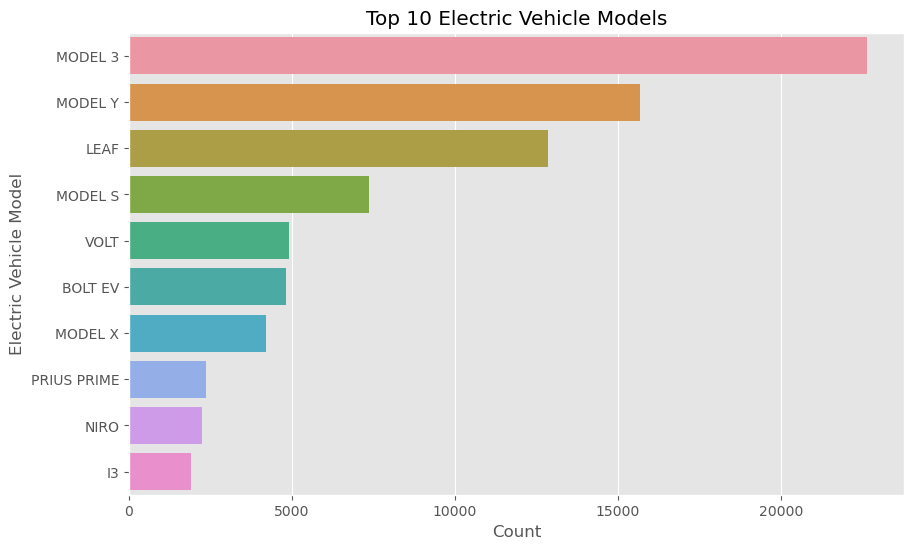

In [17]:
# extract the top 10 electric vehicle models
top_models = df['Model'].value_counts().nlargest(10)

# create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_models.values, y=top_models.index)
plt.xlabel('Count')
plt.ylabel('Electric Vehicle Model')
plt.title('Top 10 Electric Vehicle Models')
plt.show()

Text(0, 0.5, 'Count')

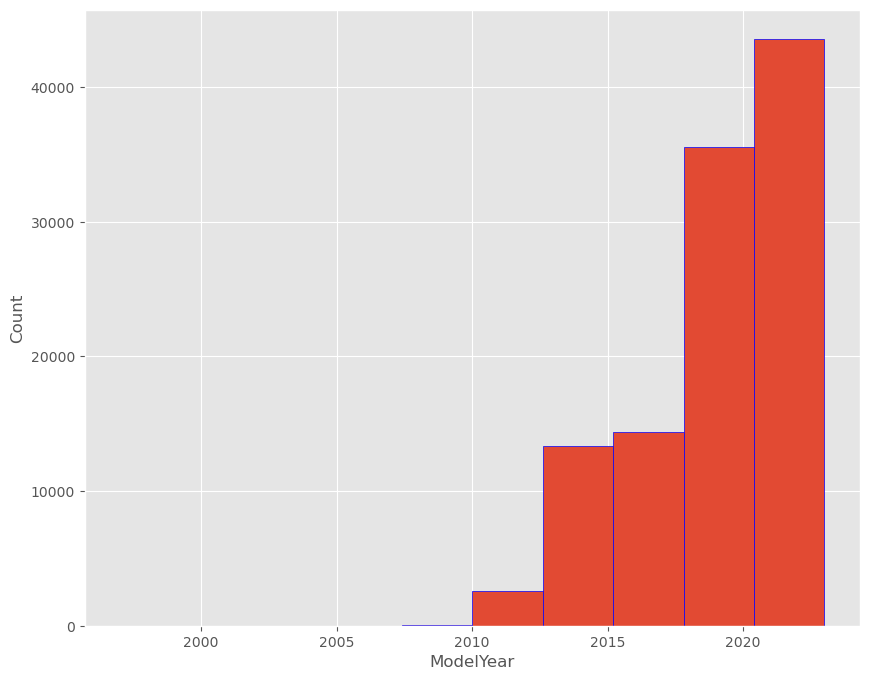

In [18]:
# Create a histogram of the Model Year variable
plt.figure(figsize = (10, 8))
plt.hist(df["ModelYear"],bins=10,edgecolor='blue')
plt.xlabel("ModelYear")
plt.ylabel("Count")

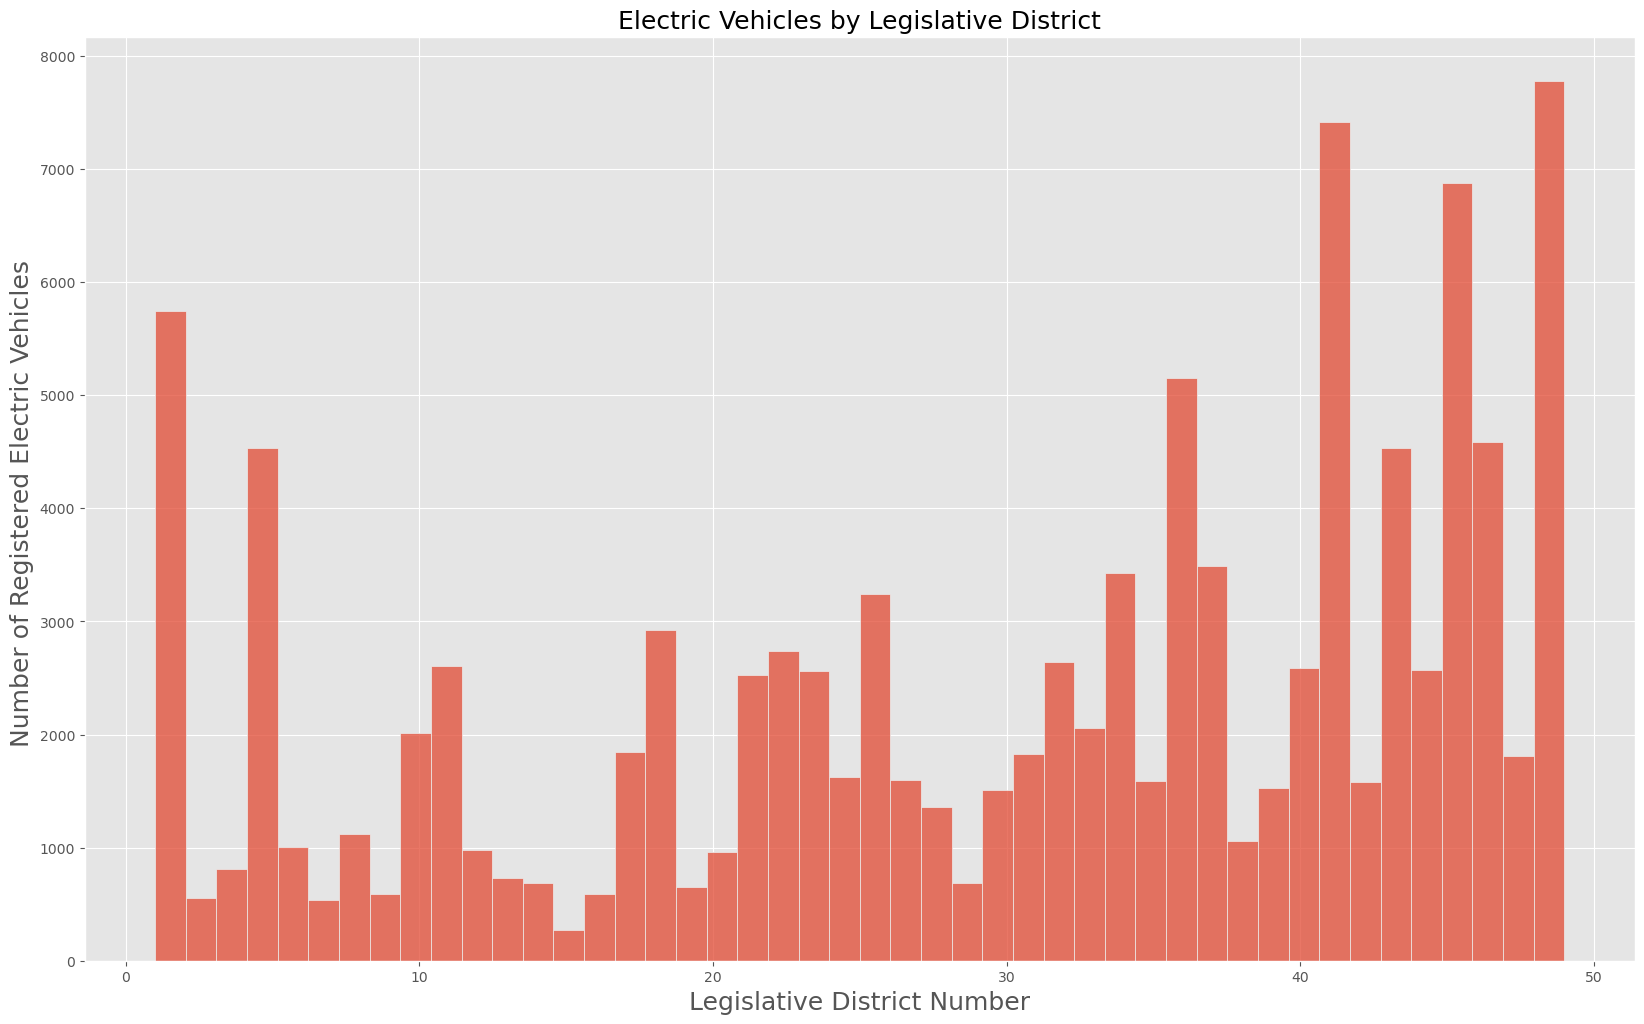

In [19]:
# create a bar plot
plt.figure(figsize=(20, 12))
sns.histplot(x='Legislative_District', data=df)
plt.xlabel('Legislative District Number', fontsize=18)
plt.ylabel('Number of Registered Electric Vehicles ',fontsize=18)
plt.title('Electric Vehicles by Legislative District',fontsize=18)
plt.show()

Text(0, 0.5, 'Count')

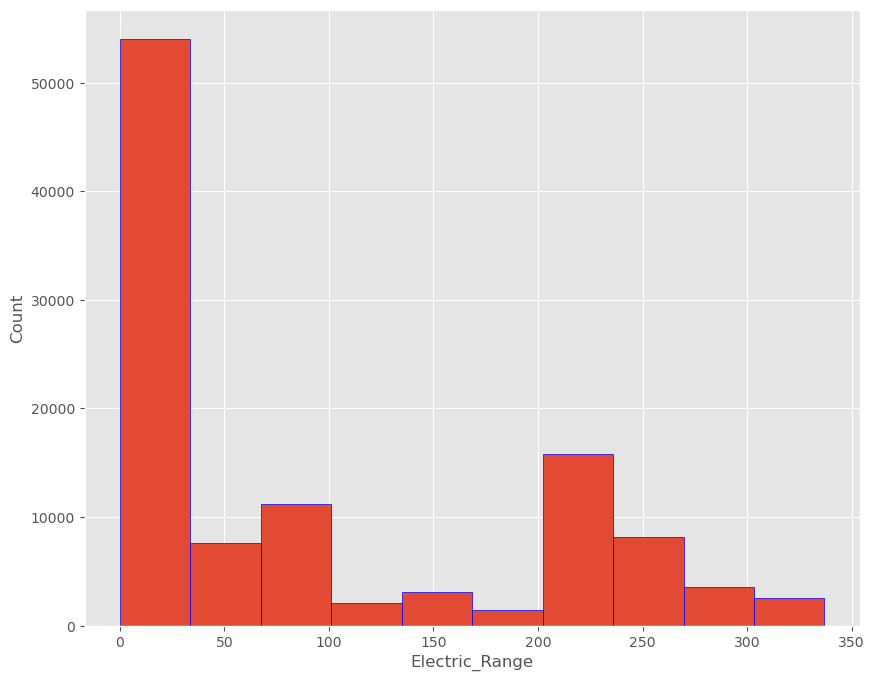

In [20]:
# Create a histogram of the Electric Range Year variable
plt.figure(figsize = (10, 8))
plt.hist(df["Electric_Range"],bins=10,edgecolor='blue')
plt.xlabel("Electric_Range")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

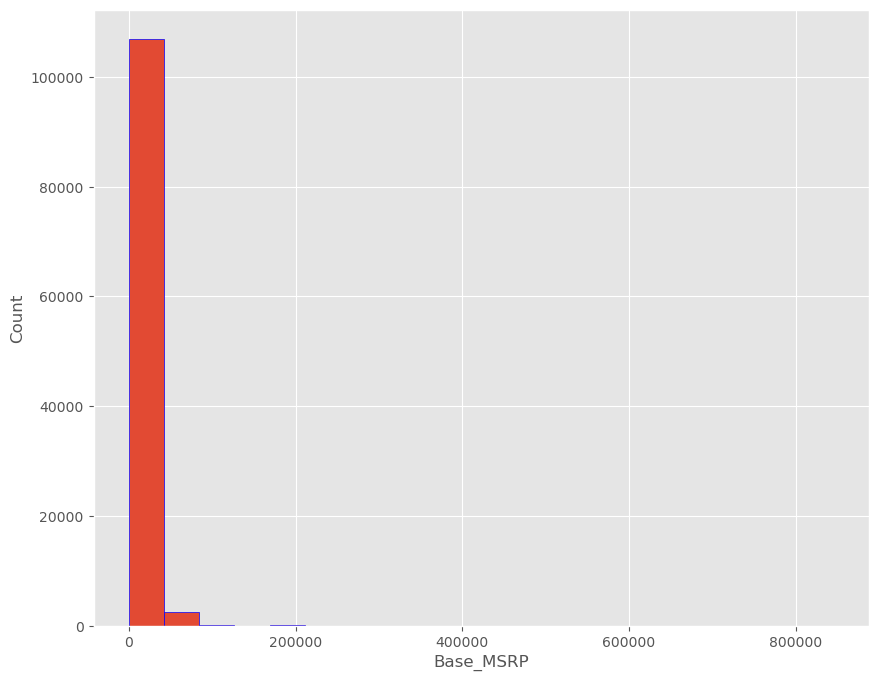

In [21]:
# Create a histogram of the Base MSRP variable
plt.figure(figsize = (10, 8))
plt.hist(df["Base_MSRP"],bins=20,edgecolor='blue')
plt.xlabel("Base_MSRP")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

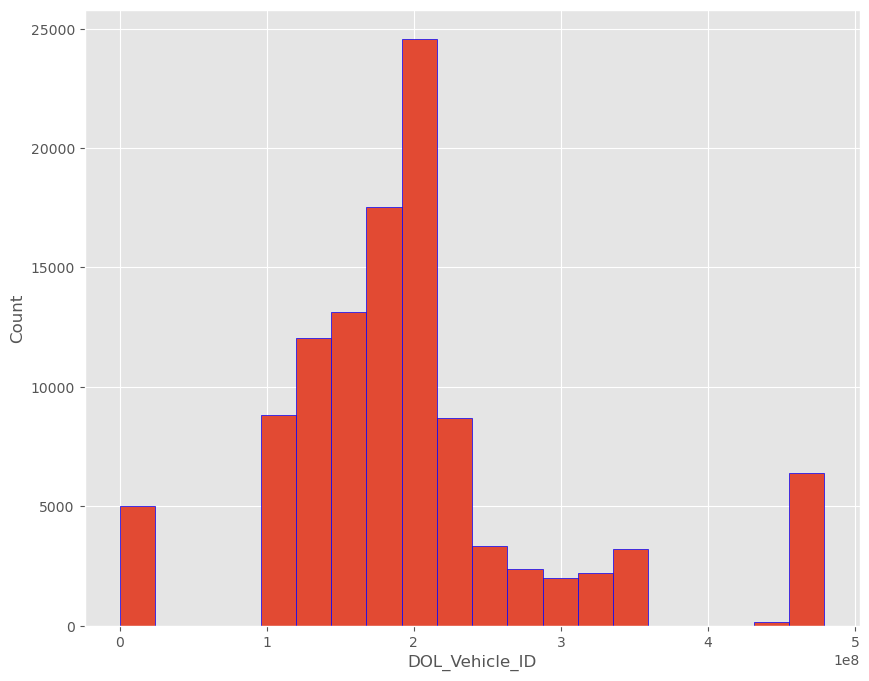

In [22]:
# Create a histogram of the DOL Vehicle ID variable
plt.figure(figsize = (10, 8))
plt.hist(df["DOL_Vehicle_ID"],bins=20,edgecolor='blue')
plt.xlabel("DOL_Vehicle_ID")
plt.ylabel("Count")

In [23]:
df.columns

Index(['VIN', 'County', 'City', 'State', 'PostalCode', 'ModelYear', 'Make',
       'Model', 'Electric_Vehicle_Type', 'CAFV_Eligibility', 'Electric_Range',
       'Base_MSRP', 'Legislative_District', 'DOL_Vehicle_ID',
       'Vehicle_Location', 'Electric_Utility', '2020_Census_Tract'],
      dtype='object')

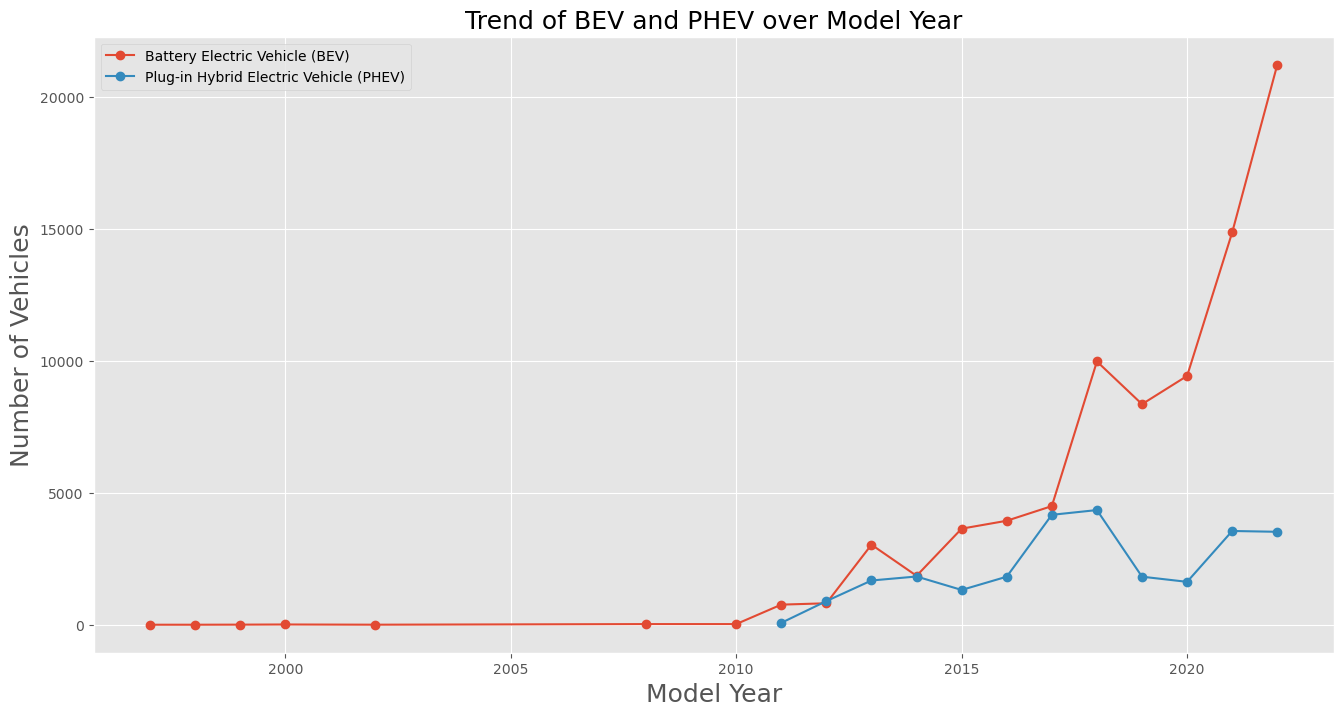

In [24]:
# Drop rows containing "2023" in the "Model Year" column
df= df.drop(df[df['ModelYear'] == 2023].index)

# reset index
df.reset_index(drop=True, inplace=True)

# Filter the data for Battery Electric Vehicle (BEV) and Plug-in Hybrid Electric Vehicle (PHEV)
filtered_ev = df[df['Electric_Vehicle_Type'].isin(['Battery Electric Vehicle (BEV)', 'Plug-in Hybrid Electric Vehicle (PHEV)'])]

# Group the filtered data by ElectricVehicleType and ModelYear
grouped_ev = filtered_ev.groupby(['Electric_Vehicle_Type', 'ModelYear']).size().reset_index(name='Counts')


# adjust the figure size
plt.figure(figsize=(16, 8))

# Create separate line plots for each electric vehicle type
for ev_type in ['Battery Electric Vehicle (BEV)', 'Plug-in Hybrid Electric Vehicle (PHEV)']:
    ev_type_data = grouped_ev[grouped_ev['Electric_Vehicle_Type'] == ev_type]

    plt.plot(ev_type_data['ModelYear'], ev_type_data['Counts'], marker='o', label=ev_type)



# Set the x-axis label
plt.xlabel('Model Year',fontsize=18)

# Set the y-axis label
plt.ylabel('Number of Vehicles',fontsize=18)

# Set the title of the plot
plt.title('Trend of BEV and PHEV over Model Year',fontsize=18)

# Add a legend
plt.legend()


# Display the plot
plt.show()

## Data Preprocessing

#### Plotting the lat and lon

In [25]:
df['lat'] = df['Vehicle_Location'].str.split(' ').str[1].str.split('(').str[1].astype(float)
df['lon'] = df['Vehicle_Location'].str.split(' ').str[2].str.split(')').str[0].astype(float)

In [26]:
df["lat"] = df["lat"].fillna(df["lat"].mean())
df["lon"] = df["lon"].fillna(df["lon"].mean())

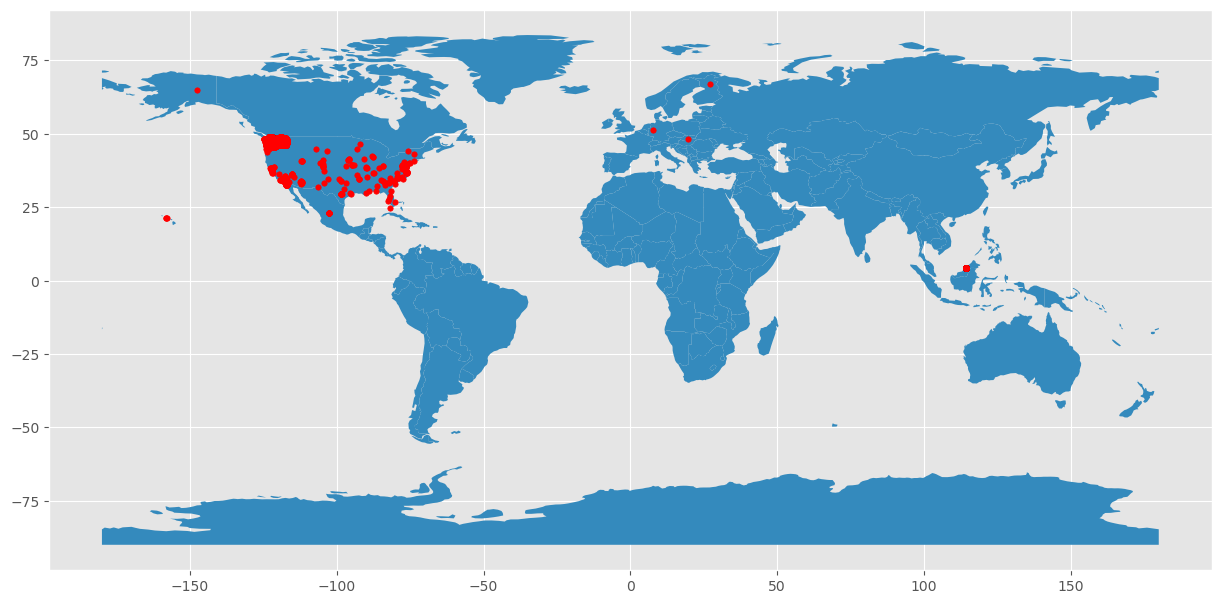

In [27]:
geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color='red', markersize=15);